In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
from math import isnan  

In [2]:
cpu = pd.read_excel("50ETF.xlsx","underlyingclose30")
cpo = pd.read_excel("50ETF.xlsx","close")

In [3]:
###  日期转换函数
def returnYear(date):
    a=date.year #转换日期
    return a

def returnMonth(date):
    a=date.month
    return a

def yearMonth(date):
    a = date.year
    b = date.month
    c=str(a)+"-"+str(b)
    return(c)
    
def yearMonthDay(date):
    a=date.year
    b=date.month
    c=date.day
    d=str(a)+"-"+str(b)+"-"+str(c)
    return(d)
    
def callorput(x):
    if(x==1):
        a='购'
        return(a)
    else:
        b='沽'
        return (b)
    
def outMoneyPrice(callput, strikeprice):  #有信号是卖潜徐值一档
    #print(strikeprice)
    if(callput == 1):
        if (strikeprice <= 3):
            interval =np.arange(0, 3.05, 0.05)#50ETF的strike在3以下是0.05为一个单位
            for j in interval:
                if j>=strikeprice:
                    str_prc=j
                    break
        elif(strikeprice > 3):
            interval =np.arange(3, 5, 0.1)#50ETF的strike是3以上是以0.1为单位
            for j in interval:
                if j>strikeprice:
                    str_prc=j
                    break
    elif (callput == -1):
        if (strikeprice <= 3):
            interval =np.arange(0, 3.05, 0.05)
            for i,j in enumerate(interval):
                if j>=strikeprice:
                    str_prc=interval[i-1]
                    break
        elif (strikeprice > 3):
            interval =np.arange(3, 5, 0.1)
            for i,j in enumerate(interval):
                if j>=strikeprice:
                    str_prc=interval[i-1]
                    break
    return (str_prc)

def atMoneyPrice(strikeprice):   #抓取平值期权
    if strikeprice<=3:
        a=round(round((strikeprice+0.0001)/0.05)*0.05,2)#-0.0001是为了将价格2.375平值视作2.35
    if strikeprice>3:
        a = round(round(strikeprice / 0.1) * 0.1,2)
    return a

In [4]:
#统计过去高低平均
a=[]#用于存放过滤参数： 15个30mins bar的均值
for i in np.arange(15,len(cpu['close'])+1,1):
    #if i<=len(cpu['close'])-120:
        a.append(np.mean(cpu['close'][i-15:i]))

In [5]:
#计算过去50ETF收盘价的高、低、均值        
high=[]#high 与 low选取24个bar的收盘价的最高价与最低价
low=[]#进场为了跟市场行情贴近一点，所以用短周期
avg=[]#average选取120个bar的均值，出场用长周期比较精确
for i in np.arange(120,len(cpu['close'])+1,1):
    avg.append(np.mean(cpu['close'][i-120:i]))

for i in np.arange(24,len(cpu['close'])+1,1):
    #if i<=(len(cpu['close'])-20):
        high.append(np.max(cpu['close'][i-24:i]))
        low.append(np.min(cpu['close'][i-24:i]))

In [6]:
"""high=filter(None,high)
low=filter(None,low)
avg=filter(None,avg)"""
######expiration date summary#####
exp_store=['2015-3-25',
             '2015-4-22',
             '2015-5-27',
             '2015-6-24',
             '2015-7-22',
             '2015-8-26',
             '2015-9-30',
             '2015-10-28',
             '2015-11-25',
             '2015-12-23',
             '2016-1-27',
             '2016-2-24',
             '2016-3-23',
             '2016-4-27',
             '2016-5-25',
             '2016-6-22',
             '2016-7-27',
             '2016-8-24',
             '2016-9-28',
             '2016-10-26',
             '2016-11-23',
             '2016-12-28',
             '2017-1-25',
             '2017-2-22',
             '2017-3-22',
             '2017-4-26',
             '2017-5-24',
             '2017-6-28',
             '2017-7-26',
             '2017-8-23',
             '2017-9-27',
             '2017-10-25',
             '2017-11-22',
             '2017-12-27',
             '2018-1-24',
             '2018-2-28',
             '2018-3-28',
             '2018-4-25',
             '2018-5-23',
             '2018-6-27',
             '2018-7-25',
             '2018-8-22',
             '2018-9-26'
             ]

In [7]:
def isexp(date):#判断日期是否超过到期日
    global t2
    t1=yearMonthDay(date)
    #print(t1)
    year=returnYear(date)
    month=returnMonth(date)
    expiration=str(year)+'-'+ str(month)+'-'
    for exp in exp_store:
        if expiration in exp:
            t2=yearMonthDay(datetime.strptime(exp,'%Y-%m-%d'))
    if t1<t2:
        return(-1)
    if t1>=t2:
        return(1)
def onexpday(date):#判断日期是否是到期日
    global t2
    t1=yearMonthDay(date)
    #print(t1)
    year=returnYear(date)
    month=returnMonth(date)
    expiration=str(year)+'-'+ str(month)+'-'
    for exp in exp_store:
        if expiration in exp:
            t2=yearMonthDay(datetime.strptime(exp,'%Y-%m-%d'))
    if t1==t2:
        return(1)
    else:
        return (-1)
    
####  这个是对日期价格找出下个月期权合约,用于到期后    
def exp_option(date, strikeprice, callput):
    type = callorput(callput)
    year = returnYear(date)
    month = returnMonth(date)
    price = str("%.2f" % ( strikeprice))
    NAME = [column for column in cpo]
    # set position
    if month < 12:
        month = month + 1 #如果这个月份到期，月份不是十二月，下一个月份还是在这一年里，简单month + 1
        string = str(type)+str(year)+"年"+str(month)+"月"+str(price)
        for i,j in enumerate(NAME):
            if string in j:
                column=i
                return (column)
    if month == 12:#如果月份为12，那么往后一个月就是下一年的一月
        year = year + 1
        month = 1
        string = str(type)+str(year)+"年"+str(month)+"月"+str(price)
        for i,name in enumerate(NAME):
            if string in name:
                column=i
                return (column)
    # offset position
    string=string = type+str(year)+"年"+str(month)+"月"+str(price)
    for i, name in enumerate(NAME):
        if string in name:
            column = i
            
def findOption(situation, date, strikeprice, callput):
    #找到相应期权
    type = callorput(callput)
    year = returnYear(date)
    month = returnMonth(date)
    #price = round(outMoneyPrice(callput, strikeprice) ,2)
    price=str("%.2f" % (outMoneyPrice(callput,strikeprice)))
 
    NAME = [column for column in cpo]
    # before expiration date,到期日前
    if situation == -1:
        string = str(type)+str(year)+"年"+str(month)+"月"+str(price)
        #print(string)
        for i,j in enumerate(NAME):
            if string in j:
                column=i
                break
        if column!= None and len(str(column))<5:
            return (column)
        else:
            return (None)
    # equal or surpass expiration date,到到期日
    if situation == 1:
        column=exp_option(date, strikeprice, callput)
        if column != None:
            return (column)
        else:
            return(None)

In [9]:
#判断position
day2=[]#
flag =0
set =0#没入场的状态
shut1 = -1 #put option
shut2 = 1#call option
shut3=2#日内交易，比如说当天就平仓
cost=None
revenue=None#卖期权的收入，不设初始值
column=None
Return =[]#return for strategy
documentTime=[]
j=0
date_infor = []
posit_infor = []
i_infor = []
revenue_infor = []
column_infor = []
row_infor = []
#这里用30分钟线
for i in np.arange(120,len(cpu['date'])-1,1):
    try:
        date = datetime.strptime(str(cpu['date'][i]), '%d/%m/%Y %H:%M')
    except:
        date = datetime.strptime(str(cpu['date'][i]), '%Y-%m-%d %H:%M:%S')
    strikeprice=cpu['close'][i]
    nowday = yearMonthDay(date)
    #判断入场条件
    ### 上升趋势，卖put
    ###  过去ma15大于ma120，价格
    if onexpday(date)==-1  and a[i-15] > avg[i-120] and  cpu['close'][i] >1.001*high[i-24] and flag != shut1 and flag != shut2 :
        #条件1：没有到期
        #条件2：满足滤网条件：15天的短周期大于120天的均值（过去价格比段时间内高一些）
        #条件3：此时标的价格大于1.001*过去24个bar的高点（价格创新高）
        #条件4：现在没有仓位flag不等于shut1 和 flag 不等于 shut2
        for k, day in enumerate(cpo['date']):
            day = yearMonthDay(day)
            if nowday == day:
                rowIndex = k
        column = findOption(situation=isexp(date), date=date, strikeprice=outMoneyPrice(1,strikeprice), callput=-1)
        # no contract needed
        if column is None:
            revenue=None
        else:
            revenue=cpo.iat[rowIndex, column]
        flag = shut1
        #print(a[i-119],high[i-119])
        date_infor.append(str(cpu['date'][i]))
        posit_infor.append(' short put ')
        i_infor.append(str(i))
        revenue_infor.append(revenue)
        column_infor.append(str(column))
        row_infor.append(str(rowIndex))
    
    #下降趋势，卖call
    elif onexpday(date)== -1  and a[i-15] < avg[i-120] and cpu['close'][i] <0.999*low[i-24] and flag != shut1 and flag != shut2 :
        #条件1：没有临近到期
        #条件2：价格创新低 0.999*过去24个bar最低价
        #条件3：没有仓位
        #条件4：短周期均值小于长周期均值
        for k, day in enumerate(cpo['date']):
            day = yearMonthDay(day)
            if nowday == day:
                rowIndex = k
        column = findOption(situation=isexp(date), date=date, strikeprice=outMoneyPrice(-1,strikeprice), callput=1)

        if column is None:
            revenue=None
        else:
            revenue=cpo.iat[rowIndex, column]
        flag = shut2

        date_infor.append(str(cpu['date'][i]))
        posit_infor.append(' short call ')
        i_infor.append(str(i))
        revenue_infor.append(revenue)
        column_infor.append(str(column))
        row_infor.append(str(rowIndex))
        
#平仓标准
    #情况1：到期平仓，不满足任何止盈止损条件，单纯持有到期
    elif onexpday(date)==1 and flag==shut1:
        for k, day in enumerate(cpo['date']):
            day = yearMonthDay(day)
            if nowday == day:
                rowIndex = k - 1
        
        if column is None:
            cost=None
        else:
            cost=cpo.iat[rowIndex, column]
        try:
            Return.append(revenue - cost-0.0015)
            day2.append(yearMonthDay(date))
        except:
            Return.append(None)
            day2.append(None)
        j=j+1
        date_infor.append(str(cpu['date'][i]))
        posit_infor.append(' buy put back ')
        i_infor.append(str(i))
        revenue_infor.append(cost)
        column_infor.append(str(column))
        row_infor.append(str(rowIndex))
        
        flag = set
    elif onexpday(date)==1 and flag==shut2:
        for k, day in enumerate(cpo['date']):
            day = yearMonthDay(day)
            if nowday == day:
                rowIndex = k - 1
        
        if column is None:
            cost=None
        else:
            cost=cpo.iat[rowIndex, column]
        try:
            Return.append(revenue - cost-0.0015)
            day2.append(yearMonthDay(date))
        except:
            Return.append(None)
            day2.append(None)
        j = j + 1
        date_infor.append(str(cpu['date'][i]))
        posit_infor.append(' buy call back ')
        i_infor.append(str(i))
        revenue_infor.append(cost)
        column_infor.append(str(column))
        row_infor.append(str(rowIndex))
        
        flag = set
        

    #情况2：未到期平仓 → 止盈止损出场
    #比如说上涨趋势是short put，把put买回来即平仓
    elif (onexpday(date)==-1) :
        for k, day in enumerate(cpo['date']):
            day = yearMonthDay(day)
            if nowday == day:
                rowIndex = k
        if column is None:
            cost = None
            Return.append(None)
            day2.append(None)
        else:
            cost = cpo.iat[rowIndex, column]  
            if (revenue - cost - 0.0015 < -0.04 or revenue - cost - 0.0015 > 0.04) and flag == shut1:
                Return.append(revenue - cost - 0.0015)
                day2.append(yearMonthDay(date))
                j = j + 1
                date_infor.append(str(cpu['date'][i]))
                posit_infor.append(' buy put back ')
                i_infor.append(str(i))
                revenue_infor.append(cost)
                column_infor.append(str(column))
                row_infor.append(str(rowIndex))
                flag = set
            elif (cpu['close'][i] < avg[i-120] and flag == shut1):
            #close price本来处于上涨趋势，如果现在低于过去120个bar，认为过去向上突破的趋势已经结束，选在买put，平仓
                Return.append(revenue - cost - 0.0015)
                day2.append(yearMonthDay(date))
                j = j + 1
                date_infor.append(str(cpu['date'][i]))
                posit_infor.append(' buy put back ')
                i_infor.append(str(i))
                revenue_infor.append(cost)
                column_infor.append(str(column))
                row_infor.append(str(rowIndex))
                flag = set
            elif (revenue - cost - 0.0015 < -0.04 or revenue - cost - 0.0015 > 0.04) and flag == shut2:
                #真实净收入小于0.04或大于0.04都选择平仓（hard limit）
                Return.append(revenue - cost - 0.0015)
                day2.append(yearMonthDay(date))
                j = j + 1
                date_infor.append(str(cpu['date'][i]))
                posit_infor.append(' buy call back ')
                i_infor.append(str(i))
                revenue_infor.append(cost)
                column_infor.append(str(column))
                row_infor.append(str(rowIndex))
                flag = set
            elif (cpu['close'][i] > avg[i-120] and flag == shut2):
                #单纯对价格止盈止损（等式如下） → revenue - cost - (slippage + service commission)
                Return.append(revenue - cost - 0.0015)
                day2.append(yearMonthDay(date))
                j = j + 1
                date_infor.append(str(cpu['date'][i]))
                posit_infor.append(' buy call back ')
                i_infor.append(str(i))
                revenue_infor.append(cost)
                column_infor.append(str(column))
                row_infor.append(str(rowIndex))
                flag = set
            else:
                continue

In [11]:
#异常值处理
R=[]
for r in Return:
    if r is  None:
        continue
    elif isnan(r):
        R.append(0)
    elif r is not None:
        R.append(round(r,4))
Return=R

In [12]:
time=[]
for j in day2:
    if j is not None:
        time.append(datetime.strptime(j,'%Y-%m-%d'))
#index 1 annualized return rate
#年化收益率（Annualized Returns)
#(策略最终价值 / 策略初始价值 - 1) / 回测交易日数量 × 250
tradetimes=len(Return)*2
fee=10.0#往返一手
amount=1000000.0#资金
marginRate=0.12#初始保证金
assuranceFactor=1.2#安全系数
maxPrice=np.max(cpu['close'])
annualizedFactor=250.0/795.0 #求年化
sum_return=np.sum(Return)*amount #fee:10/time
#margin=maxPrice*amount*marginRate*assuranceFactor
margin=1000000
# margin rate:12%;assurance factor:1.2
annualRate_1=round(((sum_return/margin))*annualizedFactor,7)
#index 2 annualized sharpe ratio
feeEach=2.0*fee/amount
return_ret_1=[]
for r in Return:
    return_ret_1.append((r*amount)/(margin))
rf=0.04 #annualized riskfree rate
#cum_return_ret_1=cumsum(return_ret_1)
annual_sharpe_Ratio_1=(annualRate_1-rf)/(np.std(return_ret_1,ddof=1)*np.sqrt(len(Return)/2.83))#python算标准差除以n-1
#index 3 annualized volatility
annual_volatility_1=(annualRate_1-rf)/annual_sharpe_Ratio_1

In [13]:
#记录最大回撤
#maxdrawdown_ret_1<-maxdrawdown(return_ret_1)
cum_Return=[]
sum=0
for k in Return:
    sum=sum+k
    cum_Return.append(sum)

money=[]
for i in cum_Return:
    money.append(amount*i+1000000)
max_drawdown =0
for e, i in enumerate(money):
    for f, j in enumerate(money):
        if f > e and float(j - i)  < max_drawdown:
            max_drawdown = float(j - i)

max_drawdownratio =0
try:
    for e, i in enumerate(money):
        for f, j in enumerate(money):
            if f > e and float(j - i)/i  < max_drawdownratio:
                max_drawdownratio = float(j - i)/i
except:
    max_drawdownratio=None

In [14]:
#记录策略胜率 → return 增加了 win的次数就+=1
win_1=0
for i in return_ret_1:
    if i>0:
        win_1=win_1+1
win_rate_1=win_1/float(len(Return))

In [16]:
print('Return')
print(Return)
print('win_rate_1','annualRate_1','annual_sharpe_Ratio_1','annual_volatility_1','max_drawdown','max_drawdownratio')

Return
[0.0369, 0.0402, 0.046, 0.0441, 0.0401, 0.03, -0.0155, 0.0768, -0.0291, 0.0144, -0.0015, 0.0672, -0.0774, 0.0469, 0.0119, -0.0559, 0.0414, 0, 0.0046, -0.0015, -0.0257, 0.0397, -0.0074, 0.0597, 0.0302, -0.0015, 0.0294, -0.0672, 0.0253, -0.0459, -0.0295, 0.0152, 0.0042, 0.0419, 0.0415, 0.0447, -0.0015, -0.0254, 0.0256, -0.0791, 0.0414, 0.0424, 0.0134, -0.0154, -0.0069, -0.0053, -0.0079, 0.0383, -0.0023, 0.0015, -0.0145, 0.039, -0.0077, 0.0351, -0.0069, 0.0223, 0.0141, -0.0042, 0.0128, 0.0068, -0.0207, 0.0457, 0.0165, -0.0085, 0.0006, -0.0233, 0.0089, -0.0135, -0.0023, 0.0155, 0.0063, 0.0056, 0.0061, -0.035, 0.0009, 0.042, 0.0209, 0.0003, 0.0099, -0.0015, -0.0008, 0.009, -0.0108, 0.0062, 0.0403, -0.0012, 0.0481, 0, -0.0005, 0, -0.0337, 0.0442, 0.0638, -0.0015, -0.0007, -0.0142, 0.0025, -0.007, 0.0286, -0.0257, -0.0163, -0.0137, 0.0809, -0.0014, -0.0112, -0.0296, 0.0408, 0.0063, -0.0241, 0.0098, -0.0015, -0.0429, -0.0042, 0.0095, -0.0374, -0.0106]
win_rate_1 annualRate_1 annual_shar

In [25]:
print('策略胜率: ',win_rate_1,'%')
print('年化收益率: ', annualRate_1,'%')
print('年化sharp ratio: ',annual_sharpe_Ratio_1,'%')
print('年化波动率: ',annual_volatility_1,'%')
print('最大回撤金额: ',max_drawdown)
print('最大回撤率: ', max_drawdownratio,'%')

策略胜率:  0.5258620689655172 %
年化收益率:  0.2406289 %
年化sharp ratio:  1.0498786025502798 %
年化波动率:  0.1910972368735286 %
最大回撤金额:  -117300.0
最大回撤率:  -0.08123268698060941 %


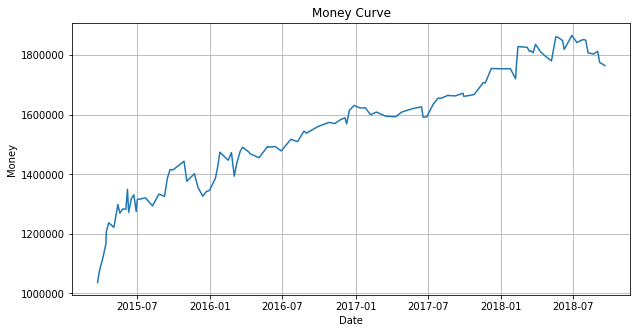

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(time, money)
plt.xlabel('Date')
plt.ylabel('Money')
plt.title('Money Curve')
plt.grid(True) 
plt.savefig("Result.png")
plt.show()